In [1]:
import numpy as np

from FlagRep import FlagRep

import itertools
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os
from skimage import color
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d

Useful functions... code from https://arxiv.org/pdf/2307.15348

In [2]:
def ll(model, eigval, n):
    """ Compute the maximum log-likelihood of a PSA model from the sample eigenvalues.
    eigval must be sorted in decreasing order.
    """
    p = np.sum(model)
    q_list = (0,) + tuple(np.cumsum(model))
    eigval_mle = np.concatenate([[np.mean(eigval[qk:qk_])] * gamma_k for (qk, qk_, gamma_k) in zip(q_list[:-1], q_list[1:], model)])
    return - (n / 2) * (p * np.log(2 * np.pi) + np.sum(np.log(eigval_mle)) + p)

def kappa(model):
    """ Compute the number of free parameters of a PSA model.
    """
    p = np.sum(model)
    kappa_mu = p
    kappa_eigvals = len(model)
    kappa_eigenspaces = int(p * (p - 1) / 2 - np.sum(np.array(model) * (np.array(model) - 1) / 2))
    return kappa_mu + kappa_eigvals + kappa_eigenspaces

def bic(model, eigval, n):
    """ Compute the Bayesian Information Criterion (BIC) of a PSA model from the sample eigenvalues.
    eigval must be sorted in decreasing order.
    """
    return kappa(model) * np.log(n) - 2 * ll(model, eigval, n)

def aic(model, eigval, n):
    """ Compute the Akaike Information Criterion (AIC) of a PSA model from the sample eigenvalues.
    eigval must be sorted in decreasing order.
    """
    return 2 * kappa(model) - 2 * ll(model, eigval, n)

def evd(X, plot_scree=False):
    """ Perform the eigenvalue decomposition (EVD) of the sample covariance matrix of X.
    Return sample eigenvalues and eigenvectors with decreasing amplitude.
    """
    n, p = X.shape
    mu = np.mean(X, axis=0)
    S = 1 / n * ((X - mu).T @ (X - mu))
    eigval, eigvec = np.linalg.eigh(S)
    eigval, eigvec = np.flip(eigval, -1), np.flip(eigvec, -1)
    if plot_scree:
        fig = plt.figure()
        plt.bar(np.arange(1, p + 1), eigval, color='k')
        plt.title("Eigenvalue scree plot")
        plt.show()
    return eigval, eigvec

def candidate_models_hierarchical(eigval, distance="relative", linkage="single"):
    """ Perform a hierarchical clustering of the sample eigenvalues for model selection.
    """
    p = len(eigval)
    updiag = np.array([[j == (i + 1) for j in range(p)] for i in range(p)]).astype('int')
    if distance == "absolute":
        metric = "euclidean"
        Z = eigval[:, None]
    elif distance == "relative":
        metric = "precomputed"
        Z = np.zeros((p, p))
        for j in range(p-1):
            Z[j, j+1] = (eigval[j] - eigval[j+1]) / eigval[j]
        Z = Z + Z.T
    else:
        raise NotImplementedError()
    clustering = AgglomerativeClustering(connectivity=updiag+updiag.T, metric=metric, linkage=linkage).fit(Z)
    merges = clustering.children_
    models = [[1,] * p]
    nodes_locations = [i for i in range(p)]
    for j, merge in enumerate(merges):
        model = models[-1].copy()
        k = min(nodes_locations.index(merge[0]), nodes_locations.index(merge[1]))
        model[k] += model[k+1]
        del model[k+1]
        models.append(model)
        nodes_locations[k] = p + j
        del nodes_locations[k+1]
    return models

def model_selection(X, candidate_models, criterion="bic"):
    """ Perform model selection by minimizing a criterion (AIC or BIC) among a family of candidate models.
    eigval must be sorted in decreasing order.
    """
    n, p = X.shape
    eigval, _ = evd(X)
    model_best = None; crit_best = np.inf
    for model in candidate_models:
        if criterion == "bic":
            crit_model = bic(model, eigval, n)
        elif criterion == "aic":
            crit_model = aic(model, eigval, n)
        else:
            raise NotImplementedError
        if crit_model < crit_best:
            model_best = model
            crit_best = crit_model
    return model_best, crit_best

def model_selection_eval(X, eigval, candidate_models, criterion="bic"):
    """ Perform model selection by minimizing a criterion (AIC or BIC) among a family of candidate models.
    eigval must be sorted in decreasing order.
    """
    n, p = X.shape
    model_best = None; crit_best = np.inf
    for model in candidate_models:
        if criterion == "bic":
            crit_model = bic(model, eigval, n)
        elif criterion == "aic":
            crit_model = aic(model, eigval, n)
        else:
            raise NotImplementedError
        if crit_model < crit_best:
            model_best = model
            crit_best = crit_model
    return model_best, crit_best

Reproducing results ... code from https://arxiv.org/pdf/2307.15348

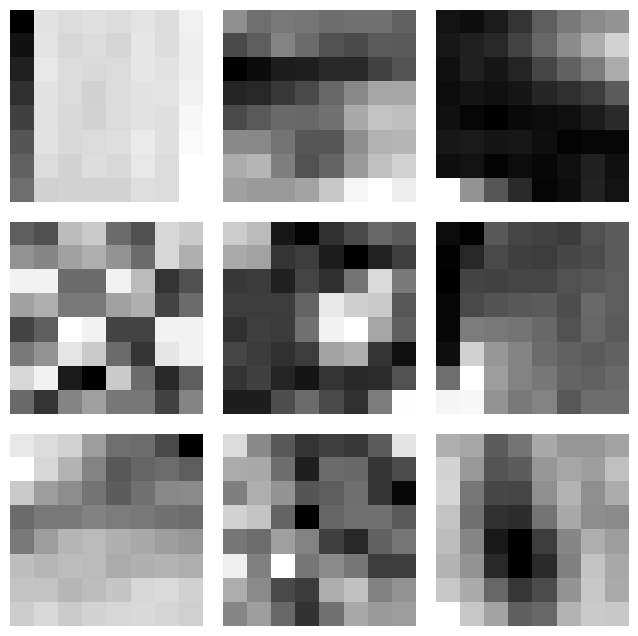

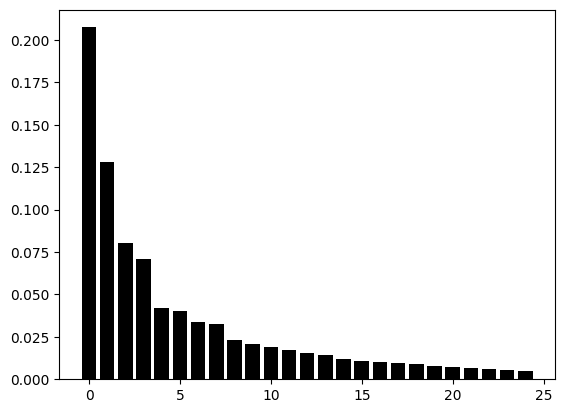

In [3]:
np.random.seed(42)

# Generate dataset
dir_name = "../data/flower_10/"
patchsize = 8
n = 500
X_img = []
for i, file in enumerate(os.listdir(dir_name)):
    img = color.rgb2gray(io.imread(dir_name+file))
    patches = extract_patches_2d(img, (patchsize, patchsize))
    patches = patches - np.mean(patches, axis=(1, 2))[:, np.newaxis, np.newaxis]  # remove DC component
    X_img.append(patches[np.random.choice(np.arange(patches.shape[0]), size=n//10, replace=False)])
X = np.concatenate(X_img, axis=0)

# Plot dataset
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[n//10 * i], cmap="gray")
    ax.axis('off')
fig.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

# Compute BIC of PPCA and PSA models
X = X.reshape((n, patchsize*patchsize))
n, p = X.shape
eigval, eigvec = evd(X)
plt.figure()
plt.bar(np.arange(25), eigval[:25], color='k')
plt.show()
bic_psa = bic((2, 3, p - 5), eigval, n)
bic_ppca = bic((1, 1, 1, 1, 1, p - 5), eigval, n)


In [4]:
models = candidate_models_hierarchical(eigval[:10])
fl_type0, bic0 = model_selection(X, models, criterion="bic")

In [5]:
fl_type = list(np.cumsum(fl_type0).astype(int))


Trying to find flags in cats and dogs

code from https://openaccess.thecvf.com/content/ICCV2023/papers/Mankovich_Chordal_Averaging_on_Flag_Manifolds_and_Its_Applications_ICCV_2023_paper.pdf

In [6]:
import torch

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import sys
sys.path.append('../scripts')

import fl_algorithms as fl
import center_algorithms as ca

In [7]:
n_pcs = 5

In [13]:
data = torch.load('../data/cats_dogs/myCATS.pt').numpy().T
p, n = data.shape

#regular PCA
eigval, eigvec = evd(data)
baseline_weights = eigvec[:,:n_pcs]

In [15]:
len(
    eigval)

4096

In [9]:
models = [[1,1,1,1,1,4096-n_pcs],
          [1,1,1,2,4096-n_pcs],[1,1,2,1,4096-n_pcs],[1,2,1,1,4096-n_pcs],[2,1,1,1,4096-n_pcs],
          [3,1,1,4096-n_pcs],[2,2,1,4096-n_pcs],[1,3,1,4096-n_pcs],[2,1,2,4096-n_pcs],[1,2,2,4096-n_pcs],[1,1,3,4096-n_pcs],
          [4,1,4096-n_pcs],[3,2,4096-n_pcs],[2,3,4096-n_pcs],[1,4,4096-n_pcs],
          [5,4096-n_pcs]]

In [10]:
n_splits = list(range(2,7,1))
n_trials = 1 #20

results = pd.DataFrame(columns = ['Number of Splits','Trial', 'Distance', 'Average']) 

In [11]:
for n_split in n_splits:

    print(f'running split {n_split}')
    for trial in range(n_trials):
        np.random.seed(trial)

        weight_data = []

        left_over = np.arange(p)
        for split in range(n_split):
            left_over = np.array(list(left_over))
            # subset data
            idx0 = np.random.choice(len(left_over), (p-1)//n_split, replace = False)
            idx = left_over[idx0]
            subset_data = data[idx, :]
            # left over idx
            left_over = set(left_over).difference(set(idx))
        

            # compute pca   
            eigval, eigvec = evd(subset_data)
            weights = eigvec[:,:n_pcs]
            weight_data.append(weights)

            fl_type0, bic0 = model_selection_eval(subset_data, eigval, models, criterion="bic")

            print(fl_type0)

running split 2
[1, 2, 2]
[2, 3]
running split 3
[2, 3]
[2, 3]
[2, 3]
running split 4
[3, 2]
[1, 4]
[2, 3]
[2, 3]
running split 5
[5]
[1, 4]
[5]
[2, 3]
[2, 3]
running split 6
[5]


KeyboardInterrupt: 

In [12]:
subset_data.shape

(32, 4096)

MNIST??

In [ ]:
from sklearn import datasets